In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['88b2c062-9-dataset']


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [4]:
import string
import nltk
from nltk.corpus import stopwords 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import re

In [5]:
!ls ../input/88b2c062-9-dataset/Dataset

Test.csv  Train.csv  sample_submission.csv


# Loading the dataset

In [6]:
df = pd.read_csv("../input/88b2c062-9-dataset//Dataset/Train.csv")
df_test = pd.read_csv("../input/88b2c062-9-dataset//Dataset/Test.csv")

In [7]:
df.shape, df_test.shape

((5566, 6), (2446, 5))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 6 columns):
Inv_Id              5566 non-null int64
Vendor_Code         5566 non-null object
GL_Code             5566 non-null object
Inv_Amt             5566 non-null float64
Item_Description    5566 non-null object
Product_Category    5566 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 261.0+ KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446 entries, 0 to 2445
Data columns (total 5 columns):
Inv_Id              2446 non-null int64
Vendor_Code         2446 non-null object
GL_Code             2446 non-null object
Inv_Amt             2446 non-null float64
Item_Description    2446 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 95.6+ KB


In [10]:
df.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376


# Understand the data

In [11]:
df['Product_Category'].iplot(kind='hist',
                             yTitle='count', 
                             title='Target Distribution', 
                             color='rgb(140,140,40)' )

In [12]:
df['Product_Category'].value_counts()

CLASS-1758    1498
CLASS-1274     986
CLASS-1522     851
CLASS-1250     451
CLASS-1376     365
CLASS-1963     230
CLASS-1249     176
CLASS-1828     113
CLASS-2141     108
CLASS-1721     107
CLASS-1567      84
CLASS-1919      70
CLASS-1850      60
CLASS-2112      53
CLASS-1477      50
CLASS-1870      36
CLASS-2241      36
CLASS-1429      32
CLASS-1309      32
CLASS-2003      32
CLASS-1964      28
CLASS-1322      28
CLASS-1294      25
CLASS-1770      19
CLASS-1983      17
CLASS-1867      15
CLASS-1652      15
CLASS-2038      13
CLASS-1805      12
CLASS-2152       9
CLASS-1248       5
CLASS-1688       4
CLASS-2146       2
CLASS-2015       2
CLASS-1957       1
CLASS-1838       1
Name: Product_Category, dtype: int64

In [13]:
def draw_distribution(train_df, test_df, feature_name, top_counts=None):
    _tmp_material = (train_df[feature_name].value_counts() /df.shape[0] * 100) [:top_counts]
    tmp_trace = go.Bar(
                x=_tmp_material.index,
                y=_tmp_material.values,
                name='training_dataset',
            )

    _tmp_material_test = (test_df[feature_name].value_counts() / df_test.shape[0] * 100) [:top_counts]
    tmp_trace_test = go.Bar(
                x=_tmp_material_test.index,
                y=_tmp_material_test.values,
                name='test_dataset'
            )

    layout = go.Layout(
            barmode='group',
            title= " Train/Test " + feature_name + " distribution",
            yaxis=dict(
                title='Counts',
            ),
#             xaxis=dict(
#                 title=feature_name,
#             )

        )

    fig = go.Figure(data=[tmp_trace, tmp_trace_test], layout=layout)
    iplot(fig)

In [14]:
draw_distribution(df, df_test, 'GL_Code')

In [15]:
print("# of unique categories in GL_Code train dataset: ", df['GL_Code'].nunique())
print("# of unique categories in GL_Code test dataset: ", df_test['GL_Code'].nunique())

# of unique categories in GL_Code train dataset:  9
# of unique categories in GL_Code test dataset:  9


In [16]:
draw_distribution(df, df_test, 'Vendor_Code', 75)

In [17]:
print("# of unique categories in Vendor_Code train dataset: ", df['Vendor_Code'].nunique())
print("# of unique categories in Vendor_Code test dataset: ", df_test['Vendor_Code'].nunique())

# of unique categories in Vendor_Code train dataset:  1253
# of unique categories in Vendor_Code test dataset:  798


In [18]:
group_labels = ['train distplot', 'test distplot']
hist_data = [df['Inv_Amt'].values, df_test['Inv_Amt']]
colors = ['#37AA9C','#37AA4C' ]

fig =ff.create_distplot(hist_data, group_labels,  colors=colors,  show_hist=False)
fig['layout'].update(title='Train/Test Inv_Amt Distribution Plot')
iplot(fig)

# Missing Values:

In [19]:
df.isnull().sum()

Inv_Id              0
Vendor_Code         0
GL_Code             0
Inv_Amt             0
Item_Description    0
Product_Category    0
dtype: int64

In [20]:
df_test.isnull().sum()

Inv_Id              0
Vendor_Code         0
GL_Code             0
Inv_Amt             0
Item_Description    0
dtype: int64

# Numerical encoding of categorical features:

In [21]:
for col in ['GL_Code', 'Vendor_Code']:
    print(col)
    le = LabelEncoder()
    le.fit(list(df[col]) + list(df_test[col]))
    df[col] = le.transform(df[col])
    df_test[col] = le.transform(df_test[col])

GL_Code
Vendor_Code


# Create Feature Matrix (X) and target (y):

In [22]:
X = df.drop('Product_Category', axis=1)
y = df.Product_Category
target = LabelEncoder()
y_endoded = target.fit_transform(y)

# Model_1 with selected features:

![Model_with_selected_features](https://github.com/asingleneuron/edgeverve_ml_challenge/blob/master/images/model_with_selected_feature.png?raw=True)

In [23]:
selected_features = ['GL_Code','Vendor_Code', 'Inv_Amt']

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X[selected_features],y_endoded, test_size=0.3, random_state=1)

# parameters of xgboost

In [25]:
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = len(target.classes_)
param['eval_metric'] = ['mlogloss']
param['seed'] = 1

In [26]:
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dvalid = xgb.DMatrix(X_valid.values, label=y_valid)
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

In [27]:
clf = xgb.train(param, dtrain, 100, evallist, verbose_eval=50)

[0]	train-mlogloss:2.30238	eval-mlogloss:2.30499
[50]	train-mlogloss:0.163168	eval-mlogloss:0.327793
[99]	train-mlogloss:0.076796	eval-mlogloss:0.30187


In [28]:
y_pred_valid = clf.predict(dvalid)
print("Accuracy : ",accuracy_score(y_valid, np.argmax(y_pred_valid, axis=1)))

Accuracy :  0.9143712574850299


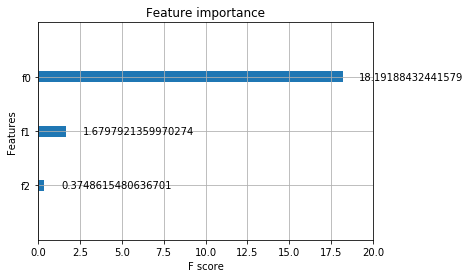

In [29]:
xgb.plot_importance(clf, importance_type='gain');

In [30]:
dtest = xgb.DMatrix(df_test[selected_features].values)
y_test_pred = clf.predict(dtest)

In [31]:
output = df_test[['Inv_Id']].copy()
output['Product_Category'] = target.inverse_transform(np.argmax(y_test_pred, axis=1))

In [32]:
output.head()

,Inv_Id,Product_Category
0,15003,CLASS-1758
1,15008,CLASS-1522
2,15013,CLASS-1522
3,15019,CLASS-1376
4,15020,CLASS-1758


In [33]:
print("Total Product Categories : {0} | predicted categories: {1} ".format(len(target.classes_), output['Product_Category'].nunique()))

Total Product Categories : 36 | predicted categories: 32 


In [34]:
output.to_csv("./product_category_submission_selected_features.csv", index=False)

# Model_2 ( BOW Features) :
![Model_with_selected_features](https://github.com/asingleneuron/edgeverve_ml_challenge/blob/master/images/mode_bow.png?raw=True)

### Add BOW(Bag of Words) Features :

In [35]:
stop_words = set(stopwords.words('english'))
def tokenize(text):
    '''
        Input: text
        Returns: clean tokens
        Desc:
            Generates a clean token of text (words) by first getting words from the text.
            Normalize the text by lowering it and removes the extra spaces, punctuation and stopwords.
    '''    
    txt = re.sub("[^A-Za-z]+", " ", text)
    tokens = txt.split()

    clean_tokens = []
    for tok in tokens:
        #
        if tok not in string.punctuation and tok not in stop_words:
            clean_tok = tok.lower().strip()
            clean_tokens.append(clean_tok)

    return clean_tokens

In [36]:
tfidf = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2), use_idf=False, max_features=None)

In [37]:
tfidf.fit(X['Item_Description'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x7f4d1996a2f0>, use_idf=False,
                vocabulary=None)

In [38]:
X_bow = tfidf.transform(X['Item_Description'])
XTest_bow = tfidf.transform(df_test['Item_Description'])

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_bow,y_endoded, test_size=0.3, random_state=1)

In [40]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

evallist = [(dtrain, 'train'), (dvalid, 'eval')]

clf = xgb.train(param, dtrain, 100, evallist, verbose_eval=50)

[0]	train-mlogloss:2.02698	eval-mlogloss:2.02699
[50]	train-mlogloss:0.014214	eval-mlogloss:0.020119
[99]	train-mlogloss:0.003764	eval-mlogloss:0.010158


In [41]:
y_pred_valid = clf.predict(dvalid)

print("Accuracy : ",accuracy_score(y_valid, np.argmax(y_pred_valid, axis=1)))

Accuracy :  0.9988023952095808


In [42]:
dtest = xgb.DMatrix(XTest_bow)
y_test_pred = clf.predict(dtest)

In [43]:
output['Product_Category'] = target.inverse_transform(np.argmax(y_test_pred, axis=1))

In [44]:
print("Total Product Categories : {0} | predicted categories: {1} "
    .format(len(target.classes_), output['Product_Category'].nunique()))

Total Product Categories : 36 | predicted categories: 33 


In [45]:
output.to_csv("./product_category_submission_bow_features.csv", index=False)

# Model_3 (OOF Prediction) : 
![OOF_Prediction](https://github.com/asingleneuron/edgeverve_ml_challenge/blob/master/images/OOF_PREDICTION.png?raw=True)


In [46]:
num_splits = 5
skf = StratifiedKFold(n_splits= num_splits, random_state=1, shuffle=True)

In [47]:
y_test_pred = np.zeros((df_test.shape[0], len(target.classes_)))
print(y_test_pred.shape)
y_valid_scores = []
X = df['Item_Description']
fold_cnt = 1
dtest = xgb.DMatrix(XTest_bow)

for train_index, test_index in skf.split(X, y_endoded):
    print("\nFOLD .... ",fold_cnt)
    fold_cnt += 1
    
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y_endoded[train_index], y_endoded[test_index]
    
    X_train_bow = tfidf.transform(X_train)
    X_valid_bow = tfidf.transform(X_valid)
    
    dtrain = xgb.DMatrix(X_train_bow, label=y_train)
    dvalid = xgb.DMatrix(X_valid_bow, label=y_valid)

    evallist = [(dtrain, 'train'), (dvalid, 'eval')]

    clf = xgb.train(param, dtrain, 100, evallist, verbose_eval=50)
    #Predict validation data
    y_pred_valid = clf.predict(dvalid)
    y_valid_scores.append(accuracy_score(y_valid, np.argmax(y_pred_valid, axis=1)))
    
    #Predict test data
    y_pred = clf.predict(dtest)
    
    y_test_pred += y_pred

(2446, 36)

FOLD ....  1


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



[0]	train-mlogloss:2.01262	eval-mlogloss:2.01859
[50]	train-mlogloss:0.013594	eval-mlogloss:0.019901
[99]	train-mlogloss:0.003253	eval-mlogloss:0.009856

FOLD ....  2
[0]	train-mlogloss:2.01312	eval-mlogloss:2.01614
[50]	train-mlogloss:0.013852	eval-mlogloss:0.016528
[99]	train-mlogloss:0.003409	eval-mlogloss:0.005302

FOLD ....  3
[0]	train-mlogloss:2.01161	eval-mlogloss:2.01149
[50]	train-mlogloss:0.013749	eval-mlogloss:0.015157
[99]	train-mlogloss:0.003394	eval-mlogloss:0.005108

FOLD ....  4
[0]	train-mlogloss:2.01373	eval-mlogloss:2.00841
[50]	train-mlogloss:0.01375	eval-mlogloss:0.01316
[99]	train-mlogloss:0.003376	eval-mlogloss:0.002973

FOLD ....  5
[0]	train-mlogloss:2.01128	eval-mlogloss:2.01065
[50]	train-mlogloss:0.013591	eval-mlogloss:0.023709
[99]	train-mlogloss:0.003286	eval-mlogloss:0.014509


In [48]:
print("Validation Scores :", y_valid_scores)
print("Average Score: ",np.round(np.mean(y_valid_scores),3))

Validation Scores : [0.9982222222222222, 0.9991055456171736, 0.9991015274034142, 1.0, 0.9972850678733032]
Average Score:  0.999


In [49]:
y_test_pred /= num_splits

In [50]:
output['Product_Category'] = target.inverse_transform(np.argmax(y_test_pred, axis=1))
print("Total Product Categories : {0} | predicted categories: {1} "
    .format(len(target.classes_), output['Product_Category'].nunique()))

Total Product Categories : 36 | predicted categories: 34 


In [51]:
output.to_csv("./product_category_submission_tfidf_oof.csv", index=False)